# Small

# Imports

In [1]:
import os
import requests
import random
import tarfile
from tqdm import tqdm

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from keras.layers import Conv2D, MaxPool2D, AvgPool2D, Dense, Flatten, Dropout, Concatenate, Input, BatchNormalization, Activation, GlobalAveragePooling2D, Rescaling, Add, UpSampling2D
from keras import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

import tensorflow.keras.datasets as tfds
from keras.utils import to_categorical, plot_model

from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt

from PIL import Image
from PIL.PngImagePlugin import PngImageFile

from IPython.display import display

# Preexisting layers

We use several models that existed before, namely Inveption and Inception V2 modules (residual connections, skip connections and batch normalization are implemented and can be toggled on), reduction block from Minception, ASPP block from DeepLab 3.

In [2]:
def inception(input_layer, filters_1x1, filters_1x1_pre3x3, filters_3x3, filters_1x1_pre5x5, filters_5x5, filters_1x1_postpool, activation=None, residual=False, skip=False, residual_scale=0.1):
  '''Implements Inception block

  Args:
  input_layer: output of previous layer
  filters_1x1: number of filters of 1x1 convolution from 1x1 branch
  filters_1x1pre3x3: number of filters of 1x1 convolution from 3x3 branch
  filters_3x3: number of filters of 3x3 convolution from 3x3 branch
  filters_1x1pre5x5: number of filters of 1x1 convolution from 5x5 branch
  filters_5x5: number of filters of 5x5 convolution from 5x5 branch
  filters_1x1_postpool: number of filters of 1x1 convolution from pooling branch
  activation: activation function applied to convolutions
  residual: if True adds residual connections, before setting to True ensure that channel number of input_layer equals filters_1x1+filters_3x3+filters_5x5+filters_1x1_postpool
  skip: if True adds skip connections, is applied after residual connection if both are True
  residual_scale: scales input_layer before adding as residual connection

  Returns:
  output of layer, shape is that of input_layer with channel dimension replaced with filters_1x1+filters_3x3+filters_5x5+filters_1x1_postpool+(input_layer channel number if skip=True)
  '''
  conv1x1=Conv2D(filters_1x1, 1, activation=activation)(input_layer)

  conv1x1pre3x3=Conv2D(filters_1x1_pre3x3, 1, activation=activation)(input_layer)
  conv3x3=Conv2D(filters_3x3, 3, padding='same', activation=activation)(conv1x1pre3x3)

  conv1x1pre5x5=Conv2D(filters_1x1_pre5x5, 1)(input_layer)
  conv5x5=Conv2D(filters_5x5, 5, padding='same', activation=activation)(conv1x1pre5x5)

  pooling3x3=MaxPool2D(3, 1, padding='same')(input_layer)
  conv1x1postpool=Conv2D(filters_1x1_postpool, 1, activation=activation)(pooling3x3)

  concat=Concatenate()([conv1x1, conv3x3, conv5x5, conv1x1postpool])
  if residual:
    added=Rescaling(residual_scale)(input_layer)
    concat=Add()([concat, added])
  return Concatenate()([concat, input_layer]) if skip else concat

def inception_v2(input_layer, filters_1x1, filters_1x1_pre3x3, filters_3x3, filters_1x1_pre3x3pair, filters_3x3pair0, filters_3x3pair1, filters_1x1_postpool, activation=None, residual=False, skip=False, residual_scale=0.1):
  '''Implements Inception block

  Args:
  input_layer: output of previous layer
  filters_1x1: number of filters of 1x1 convolution from 1x1 branch
  filters_1x1pre3x3: number of filters of 1x1 convolution from 3x3 branch
  filters_3x3: number of filters of 3x3 convolution from 3x3 branch
  filters_1x1pre3x3pair: number of filters of 1x1 convolution from 3x3 pair branch
  filters_3x3pair0: number of filters of first 3x3 convolution from 3x3 pair branch
  filters_3x3pair1: number of filters of second 3x3 convolution from 3x3 pair branch
  filters_1x1_postpool: number of filters of 1x1 convolution from pooling branch
  activation: activation function applied to convolutions
  residual: if True adds residual connections, before setting to True ensure that channel number of input_layer equals filters_1x1+filters_3x3+filters_3x3pair1+filters_1x1_postpool
  skip: if True adds skip connections, is applied after residual connection if both are True
  residual_scale: scales input_layer before adding as residual connection

  Returns:
  output of layer, shape is that of input_layer with channel dimension replaced with filters_1x1+filters_3x3+filters_3x3pair1+filters_1x1_postpool+(input_layer channel number if skip=True)
  '''
  conv1x1=Conv2D(filters_1x1, 1, activation=activation)(input_layer)

  conv1x1pre3x3=Conv2D(filters_1x1_pre3x3, 1, activation=activation)(input_layer)
  conv3x3=Conv2D(filters_3x3, 3, padding='same', activation=activation)(conv1x1pre3x3)

  conv1x1pre3x3pair=Conv2D(filters_1x1_pre3x3pair, 1, activation=activation)(input_layer)
  conv3x3pair0=Conv2D(filters_3x3pair0, 3, padding='same', activation=activation)(conv1x1pre3x3pair)
  conv3x3pair1=Conv2D(filters_3x3pair1, 3, padding='same', activation=activation)(conv3x3pair0)

  pooling3x3=MaxPool2D(3, 1, padding='same')(input_layer)
  conv1x1postpool=Conv2D(filters_1x1_postpool, 1, activation=activation)(pooling3x3)
  
  concat=Concatenate()([conv1x1, conv3x3, conv3x3pair1, conv1x1postpool])
  if residual:
    added=Rescaling(residual_scale)(input_layer)
    concat=Add()([concat, added])
  return Concatenate()([concat, input_layer]) if skip else concat

def reduction(input_layer, filters_3x3trio_s2, filters_3x3trio_1, filters_3x3trio_2, filters_3x3s2, batch_normalization=False, activation=None):
  '''Implements reduction block from Minception

  Args:
  input_layer: output of previous layer
  filters_3x3trio_s2: number of filters of first 3x3 convolution (which has strides=2) from 3x3 trio branch
  filters_3x3trio_1: number of filters of second 3x3 convolution from 3x3 trio branch
  filters_3x3trio_2: number of filters of third 3x3 convolution from 3x3 trio branch
  filters_3x3s2: number of filters of 3x3 convolution vith strides=2 from 3x3 branch
  batch_normalization: adds batch normalization if True
  activation: activation function applied to convolutions

  Returns:
  output of layer, shape is [batch dimension of input_layer, first spatial dimension of input layer / 2, second spatial dimension of input_layer / 2, filters_3x3trio_2+filters_3x3s2+channel dimension of input_layer]
  '''
  conv3x3trio_s2=Conv2D(filters_3x3trio_s2, 3, strides=2, padding='same')(input_layer)
  if batch_normalization:
    conv3x3trio_s2=BatchNormalization()(conv3x3trio_s2)
  conv3x3trio_s2=Activation(activation)(conv3x3trio_s2)
  conv3x3trio1=Conv2D(filters_3x3trio_1, 3, padding='same')(conv3x3trio_s2)
  if batch_normalization:
    conv3x3trio1=BatchNormalization()(conv3x3trio1)
  conv3x3trio1=Activation(activation)(conv3x3trio1)
  conv3x3trio2=Conv2D(filters_3x3trio_2, 3, padding='same')(conv3x3trio1)
  if batch_normalization:
    conv3x3trio2=BatchNormalization()(conv3x3trio2)
  conv3x3trio2=Activation(activation)(conv3x3trio2)

  conv3x3s2=Conv2D(filters_3x3s2, 3, strides=2, padding='same')(input_layer)
  if batch_normalization:
    conv3x3s2=BatchNormalization()(conv3x3s2)
  conv3x3s2=Activation(activation)(conv3x3s2)

  pooling3x3=MaxPool2D(3, strides=2)(input_layer)

  return Concatenate()([conv3x3trio2, conv3x3s2, pooling3x3])

In [3]:
def ASPP(input_layer, filters_size_rate_list, filters_1x1global, batch_normalization=False, activation=None):
  '''Implements ASPP

  Args:
  input_layer: output of previous layer
  filters_size_rate_list: list of tuples (filter number, kernel size, dilation rate) for parallel atrous convolution layers
  filters_1x1global: number of filters applied to 1x1 convolution on global pooling
  batch_normalization: if True applies batch normalization
  activation: activation function applied to convolution outputs

  Returns:
  output of layer, size is that of input_layer with channel dimension replaced with sum of filter numbers from filters_size_rate_list + filters_1x1global
  '''
  concat_list=[]
  for filters_size_rate in filters_size_rate_list:
    conv=Conv2D(filters_size_rate[0], filters_size_rate[1], dilation_rate=filters_size_rate[2], padding='same')(input_layer)
    if batch_normalization:
      conv=BatchNormalization()(conv)
    conv=Activation(activation)(conv)
    concat_list.append(conv)
  global_pool=GlobalAveragePooling2D(keepdims=True)(input_layer)
  conv1x1global=Conv2D(filters_1x1global, 1)(global_pool)
  if batch_normalization:
    conv1x1global=BatchNormalization()(conv1x1global)
  conv1x1global=Activation(activation)(conv1x1global)
  conv1x1global=UpSampling2D(input_layer.shape[1:3], interpolation='bilinear')(conv1x1global)
  concat_list.append(conv1x1global)
  return Concatenate()(concat_list)

# Statistical functions

## Show train/validation metrics graphics

In [4]:
def show_train_graphs(history, metrics=['accuracy', 'loss'], figsize=(15, 5), column_num=2):
    plt.figure(figsize=figsize)
    row_num = int(np.ceil(len(metrics)/column_num))
    for i, metric in enumerate(metrics):
        plt.subplot(row_num, column_num, i+1)
        plt.plot(history.history[metric], label='train')
        plt.plot(history.history['val_' + metric], label='validation')
        plt.legend()
        plt.title(metric)

    plt.show()

## Show heatmap

In [5]:
def make_prediction(model, x_test, y_test):
  y_predict = model.predict(x_test, verbose=1)
  y_predict = y_predict.argmax(axis=1)
  return y_test.argmax(axis=1), y_predict

def show_prediction_results_deployed(model, x_test, y_test):
  y_test, y_predict = make_prediction(model, x_test, y_test)
  data = pd.DataFrame(classification_report(y_test, y_predict, output_dict=True, )).T
  data = data.applymap(lambda x: round(x,4))

  display(data)
  sns.heatmap(confusion_matrix(y_test, y_predict), annot = True, fmt='.0f')

# RetinaLike layers

Retina like layers implement the idea of having small high-resolution vision region, surrounded by low-resolution, like in human eyes, where there's a small high-resolution image of retina - fovea.

## Simple

Simple implementation consists of parallel processing of small high-resolution region and larger low-resolution region.

In [6]:
def retina_like(input_layer, kernel_size, filters_regular,
                filters_atrous,
                vision_rate=3, pool_function=AvgPool2D, activation=None,
                skip=False):
    '''Implements retina_like layer which has central high-resolution region surrounded by larger low-resolution region.

    Args:
    input_layer: output of previous layer
    kernel_size: size of high resolution region
    filters_regular: number of filters applied to high-resolution region
    filters_atrous: number of filters applied to low-resolution region
    vision_rate: relative size of low-resolution field (it's actual size is vision_rate*kernel_size)
    pool_function: pooling used for making low-resolution region
    activation: activation applied to convolutions
    skip: adds skip connections

    Returns:
    output of layer, shape equals input_layer shape with channel dimension replaced by filters_regular+filters_atrous
    '''
    conv_regular = Conv2D(filters_regular, kernel_size, padding='same', activation=activation)(input_layer)

    pool = pool_function((kernel_size, kernel_size), strides=(1, 1), padding='same')(input_layer)
    conv_atrous = Conv2D(filters_atrous, vision_rate, dilation_rate=kernel_size, padding='same', activation=activation)(
        pool)

    return Concatenate()([conv_regular, conv_atrous] + ([input_layer] if skip else []))

## Deep architecture

Deep architecture adds 1x1 convolution layers to mix information collected from high-resolution region and low-resolution region.

In [7]:
def deep_retina_like(input_layer, kernel_size, filters_regular,
                     filters_atrous,
                     filters_activations_list,
                     vision_rate=3, pool_function=AvgPool2D, activation_retina=None,
                     skip=False):
    '''Implements retina_like layer with 1x1 convolutions stacked on top of it.

    Args:
    input_layer: output of previous layer
    kernel_size: size of high resolution region
    filters_regular: number of filters applied to high-resolution region
    filters_atrous: number of filters applied to low-resolution region
    filters_activations_list: list of (filters, activation) typles which provide number of filters and activation functions for 1x1 convolution layers added on top of retina_like
    vision_rate: relative size of low-resolution field (it's actual size is vision_rate*kernel_size)
    pool_function: pooling used for making low-resolution region
    activation_retina: activation applied to convolutions of retina_like
    skip: adds skip connections

    Returns:
    output of layer, shape equals input_layer shape with channel dimension replaced by filters of last tuple in filters_activations_list
    '''
    input_layer = retina_like(input_layer, kernel_size, filters_regular, filters_atrous, vision_rate, pool_function,
                              activation=activation_retina, skip=skip)
    for filters_activations in filters_activations_list:
        input_layer = Conv2D(filters_activations[0], 1, activation=filters_activations[1])(input_layer)
    return input_layer

## Summation retina

Another approach to mixing information is to sum it, connecting parallel convolutions into one filter.

In [8]:
def retina_sum(input_layer, kernel_size, filters, vision_rate=3, pool_function=AvgPool2D, activation=None):
    '''Implements retina_like layer which sums information from high- and low-resolution regions.

    Args:
    input_layer: output of previous layer
    kernel_size: size of high resolution region
    filters: number of filters
    vision_rate: relative size of low-resolution field (it's actual size is vision_rate*kernel_size)
    pool_function: pooling used for making low-resolution region
    activation: activation applied to convolutions

    Returns:
    output of layer, shape equals input_layer shape with channel dimension replaced by filters
    '''
    conv_regular = Conv2D(filters, kernel_size, padding='same')(input_layer)

    pool=pool_function(kernel_size, strides=(1,1), padding='same')(input_layer)
    conv_atrous=Conv2D(filters, vision_rate, dilation_rate=kernel_size, padding='same')(pool)

    sum=Add()([conv_regular, conv_atrous])

    return Activation(activation)(sum)

## Retina inception

Modified version of inception blocks, convolutions with kernel size more than 1x1 are replaced with retina_like layer of same kernel size.

### v1

Modification of original inception block? which contained 1x1 convolution, 3x3 convolution (replaced with 3x3 retina_like) preceded by 1x1 convolution for dimensionality reduction, 5x5 convolution (replaced by 5x5 retina_like) preceded by 1x1 convolution for dimensionality reduction, and 3x3 pooping followed by 1x1 convolution in parallel.

In [9]:
def retina_inception(input_layer, filters_1x1, filters_1x1_pre3x3, filters_regular_3x3, filters_atrous_3x3, filters_1x1_pre5x5, filters_regular_5x5, filters_atrous_5x5, filters_1x1_postpool, vision_rate_3x3=3, vision_rate_5x5=3, pool_function=AvgPool2D, activation=None, activation_retina=None, batch_normalization=False, residual=False, skip=False, residual_scale=0.1):
  '''Implements inception block with convolutions larger than 1x1 replaced with corresponding retina_like layers.
  
  Args:
  input_layer: output of previous layer
  filters_1x1: filter number of 1x1 convolution from 1x1 branch
  filters_1x1_pre3x3: filter number of 1x1 convolution from 3x3 branch
  filters_regular_3x3: filter number of high-resolution region of 3x3 retina_like from 3x3 branch
  filters_atrous_3x3: filter number of low-resolution region of 3x3 retina_like from 3x3 branch
  filters_1x1_pre5x5: filter number of 1x1 convolution from 5x5 branch
  filters_regular_5x5: filter number of high-resolution region of 5x5 retina_like from 5x5 branch
  filters_atrous_5x5: filter number of low-resolution region of 5x5 retina_like from 5x5 branch
  filters_1x1_postpool: filter number of 1x1 convolution from pooling branch
  vision_rate_3x3: vision rate of 3x3 retina_like from 3x3 branch
  vision_rate_5x5: vision rate of 5x5 retina_like from 5x5 branch
  pool_function: pooling used for making low-resolution regions
  activation: activation of convolution layers
  activation_retina: activation of retina_like layers
  batch_normalization: applies batch normalization if True
  residual: adds residual connections if True, ensure that input_layer channel number equals filters_1x1+filters_regular_3x3+filters_atrous_3x3+filters_regular_5x5+filters_atrous_5x5+filters_1x1_postpool before setting to True
  skip: adds skip connections if True, is applied after residual connection if both are True
  residual_scale: scales input_layer before adding to inception block output as residual connection

  Returns:
  output of layer, shape equals that of input_layer shape with channel dimension replaced with filters_1x1+filters_regular_3x3+filters_atrous_3x3+filters_regular_5x5+filters_atrous_5x5+filters_1x1_postpool+(number of input_layer channels if skip=True)
  '''
  conv1x1=Conv2D(filters_1x1, 1, padding='same')(input_layer)
  if batch_normalization:
    conv1x1=BatchNormalization()(conv1x1)
  conv1x1=Activation(activation)(conv1x1)

  conv1x1pre3x3=Conv2D(filters_1x1_pre3x3, 1, padding='same')(input_layer)
  if batch_normalization:
    conv1x1pre3x3=BatchNormalization()(conv1x1pre3x3)
  conv1x1pre3x3=Activation(activation)(conv1x1pre3x3)
  retina3x3=retina_like(conv1x1pre3x3, 3, filters_regular_3x3, filters_atrous_3x3, vision_rate_3x3, pool_function, None)
  if batch_normalization:
    retina3x3=BatchNormalization()(retina3x3)
  retina3x3=Activation(activation_retina)(retina3x3)

  conv1x1pre5x5=Conv2D(filters_1x1_pre5x5, 1, padding='same')(input_layer)
  if batch_normalization:
    conv1x1pre5x5=BatchNormalization()(conv1x1pre5x5)
  conv1x1pre5x5=Activation(activation)(conv1x1pre5x5)
  retina5x5=retina_like(conv1x1pre5x5, 3, filters_regular_5x5, filters_atrous_5x5, vision_rate_5x5, pool_function, None)
  if batch_normalization:
    retina5x5=BatchNormalization()(retina5x5)
  retina5x5=Activation(activation_retina)(retina5x5)

  pooling3x3=MaxPool2D(3, strides=1, padding='same')(input_layer)
  conv1x1postpool=Conv2D(filters_1x1_postpool, 1)(pooling3x3)
  if batch_normalization:
    conv1x1postpool=BatchNormalization()(conv1x1postpool)
  conv1x1postpool=Activation(activation)(conv1x1postpool)

  concat=Concatenate()([conv1x1, retina3x3, retina5x5, conv1x1postpool])
  if residual:
    added=Rescaling(residual_scale)(input_layer)
    concat=Add()([concat, added])

  return Concatenate()([concat, input_layer]) if skip else concat

### v2

Modification of inception v2 block, which factorized 5x5 convolution from previous version with 2 subsequent 3x3 convolution (here both are replaced with 3x3 retina_like).

In [10]:
def retina_inception_v2(input_layer,
                        filters_1x1,
                        filters_1x1_pre3x3, filters_regular_3x3, filters_atrous_3x3,
                        filters_1x1_pre3x3pair, filters_regular_3x3pair0, filters_atrous_3x3pair0,
                        filters_regular_3x3pair1, filters_atrous_3x3pair1,
                        filters_1x1_postpool,
                        vision_rate_3x3=3, vision_rate_3x3pair=3,
                        pool_function=AvgPool2D,
                        activation=None, activation_retina=None):
    '''Implements inception block with convolutions larger than 1x1 replaced with corresponding retina_like layers.
    
    Args:
    input_layer: output of previous layer
    filters_1x1: filter number of 1x1 convolution from 1x1 branch
    filters_1x1_pre3x3: filter number of 1x1 convolution from 3x3 branch
    filters_regular_3x3: filter number of high-resolution region of 3x3 retina_like from 3x3 branch
    filters_atrous_3x3: filter number of low-resolution region of 3x3 retina_like from 3x3 branch
    filters_1x1_pre3x3pair: filter number of 1x1 convolution from 3x3 pair branch
    filters_regular_3x3pair0: filter number of high-resolution region of first 3x3 retina_like from 3x3 pair branch
    filters_atrous_3x3pair0: filter number of low-resolution region of first 3x3 retina_like from 3x3 pair branch
    filters_regular_3x3pair1: filter number of high-resolution region of second 3x3 retina_like from 3x3 pair branch
    filters_atrous_3x3pair1: filter number of low-resolution region of second 3x3 retina_like from 3x3 pair branch
    filters_1x1_postpool: filter number of 1x1 convolution from pooling branch
    vision_rate_3x3: vision rate of 3x3 retina_like from 3x3 branch
    vision_rate_3x3pair: vision rate of 3x3 retina_like layers from 3x3 pair branch
    pool_function: pooling used for making low-resolution regions
    activation: activation of convolution layers
    activation_retina: activation of retina_like layers

    Returns:
    output of layer, shape equals that of input_layer shape with channel dimension replaced with filters_1x1+filters_regular_3x3+filters_atrous_3x3+filters_regular_3x3pair1+filters_atrous_3x3pair1+filters_1x1_postpool
    '''
    conv1x1 = Conv2D(filters_1x1, 1, activation=activation, padding='same')(input_layer)

    conv1x1pre3x3 = Conv2D(filters_1x1_pre3x3, 1, activation=activation, padding='same')(input_layer)
    retina3x3 = retina_like(conv1x1pre3x3, 3, filters_regular_3x3, filters_atrous_3x3, vision_rate_3x3, pool_function,
                            activation_retina)

    conv1x1pre3x3pair = Conv2D(filters_1x1_pre3x3pair, 1, activation=activation, padding='same')(input_layer)
    retina3x3pair0 = retina_like(conv1x1pre3x3pair, 3, filters_regular_3x3pair0, filters_atrous_3x3pair0,
                                 vision_rate_3x3pair, pool_function, activation_retina)
    retina3x3pair1 = retina_like(retina3x3pair0, 3, filters_regular_3x3pair1, filters_atrous_3x3pair1,
                                 vision_rate_3x3pair, pool_function, activation_retina)

    pooling3x3 = MaxPool2D(3, strides=1, padding='same')(input_layer)
    conv1x1postpool = Conv2D(filters_1x1_postpool, 1, activation=activation)(pooling3x3)

    return Concatenate()([conv1x1, retina3x3, retina3x3pair1, conv1x1postpool])

# Classification task (fashion MNIST)

## Classification task constants

In [11]:
train_valid_size = 0.2
shape_of_fashion_mnist = (28,28,1)

arr_of_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

## Import data (fashion MNIST)

Label Description

0.	T-shirt/top
1.	Trouser
2.	Pullover
3.	Dress
4.	Coat
5.	Sandal
6.	Shirt
7.	Sneaker
8.	Bag
9.	Ankle boot

In [12]:
(x_train_full, y_train_full), (x_test, y_test)=tfds.fashion_mnist.load_data()
x_train, x_valid, y_train, y_valid = train_test_split(x_train_full, y_train_full, test_size=train_valid_size)

4422102/4422102 [==============================] - 0s 0us/step


### show

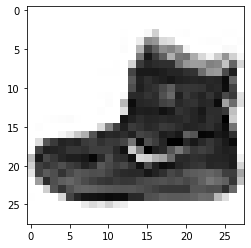

In [13]:
plt.imshow(x_train_full[0], cmap='Greys')

In [ ]:
data = {}
for i in np.unique(y_train_full):
  images = x_train_full[y_train_full==i]
  data[arr_of_names[i]] = [images.shape[0]]
data = pd.DataFrame(data).T
data.rename(columns={0:'instance_numbers'})

In [ ]:
column_num=3
instance_num = np.unique(y_train_full).shape[0]
row_num = int(np.ceil(instance_num/column_num))

plt.figure(figsize=(15,20))
for j, i in enumerate(np.unique(y_train_full)):
    plt.subplot(row_num, column_num, j+1)
    plt.imshow(x_train_full[y_train_full==i][0], cmap='Greys')
    plt.title(arr_of_names[i])
plt.show()

In [ ]:
class_number=6
column_num=3
instance_num=12
row_num = int(np.ceil(instance_num/column_num))

plt.figure(figsize=(15,20))
images = x_train_full[y_train_full==class_number]
for i in range(instance_num):
    plt.subplot(row_num, column_num, i+1)
    plt.imshow(images[i], cmap='Greys')
    plt.title(arr_of_names[class_number])

plt.show()

### preprocess

In [14]:
x_train = x_train.reshape([-1,28,28,1])
x_valid = x_valid.reshape([-1,28,28,1])
x_test  = x_test.reshape( [-1,28,28,1])

x_train = x_train/255.0
x_valid = x_valid/255.0
x_test = x_test/255.0

In [15]:
y_test  = to_categorical(y_test , dtype ="uint8")
y_train = to_categorical(y_train, dtype ="uint8")
y_valid = to_categorical(y_valid, dtype ="uint8")

### check

In [16]:
y_test[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1], dtype=uint8)

## Model

### Creating

#### Small architecture

In [17]:
def small_model():
    input_layer = Input(shape_of_fashion_mnist)
    x = deep_retina_like(input_layer, 3, 64, 32,
                        [(64, 'relu'), (32, 'relu')],
                        activation_retina='relu')
    x = MaxPool2D((2,2))(x)
    x = deep_retina_like(x, 3, 64, 32,
                        [(64, 'relu'), (32, 'relu')],
                        activation_retina='relu')
    x = MaxPool2D((2,2))(x)
    x = deep_retina_like(x, 3, 64, 32,
                        [(64, 'relu'), (32, 'relu')],
                        activation_retina='relu')
    x = Flatten()(x)
    x = Dropout(0.75)(x)
    x = Dense(100, activation='relu')(x)
    x = Dropout(0.65)(x)
    x = Dense(10, activation='softmax')(x)
    return input_layer, x

#### Big architecture

In [18]:
def big_model():
    input_layer = Input(shape_of_fashion_mnist)

    x=retina_like(input_layer, 3, 64, 32, activation='relu')

    x=retina_inception(x, 32, 32, 64, 16, 16, 16, 16, 16, activation='relu')

    x=inception(x, 32, 32, 64, 16, 16, 16, activation='relu')

    x=inception(x, 32, 32, 64, 16, 16, 16, activation='relu')

    x=deep_retina_like(x, 3, 64, 32, [(128, 'relu'),(128, 'relu')])
    x=Conv2D(64, 3, activation='relu')(x)

    x = Flatten()(x)
    x = Dropout(0.93)(x)
    x = Dense(128, activation='relu')(x)

    x = Dense(10, activation='softmax')(x)

    return input_layer, x
# better used with learning rate scheduler

In [19]:
model_type = 'small'
input_layer, x = None, None
if model_type == 'big':
    input_layer, x = big_model()
elif model_type == 'small':
    input_layer, x = small_model()
model = Model(inputs=input_layer, outputs=x, name="mnist_model")

In [ ]:
class_weights={
    0:1,
    1:1,
    2:1,
    3:1,
    4:1,
    5:1,
    6:2,
    7:1,
    8:1,
    9:1,
}

if model_type == 'small':
    class_weights[6] = 1.25

#### Show model

In [20]:
model.summary()

Model: "mnist_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 average_pooling2d (AveragePool  (None, 28, 28, 1)   0           ['input_1[0][0]']                
 ing2D)                                                                                           
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 64)   1664        ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 28, 28, 32)   320         ['average_pooling2d[0][

In [ ]:
plot_model(model, show_shapes=True)

### Training

In [ ]:
learn_rate = None
if model_type == 'small':
    learn_rate = 0.0001
elif model_type == 'big':
    learn_rate = tf.keras.optimizers.schedules.ExponentialDecay(0.00015, 1500, 0.93, staircase=True)

In [27]:
model.compile(optimizer=Adam(0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [28]:
epochs = 50

checkpointer = ModelCheckpoint(
    filepath=f'RetinaBased_{model_type}.model.{epochs}epochs.hdf5', 
    save_best_only=True, 
    monitor="val_loss")


history=model.fit(x_train, y_train, 
          batch_size=32, 
          epochs=epochs, 
          verbose=1, 
          validation_data=(x_valid, y_valid),
          class_weight=class_weights,
          callbacks=[checkpointer])

Epoch 1/10
1500/1500 [==============================] - 78s 50ms/step - loss: 7.7754 - accuracy: 0.2106 - val_loss: 1.8659 - val_accuracy: 0.2711
Epoch 2/10
1500/1500 [==============================] - 75s 50ms/step - loss: 1.9109 - accuracy: 0.2614 - val_loss: 2.0561 - val_accuracy: 0.1947
Epoch 3/10
1500/1500 [==============================] - 76s 51ms/step - loss: 1.8871 - accuracy: 0.2724 - val_loss: 1.8742 - val_accuracy: 0.3265
Epoch 4/10
  82/1500 [>.............................] - ETA: 1:06 - loss: 1.7848 - accuracy: 0.2919

KeyboardInterrupt: KeyboardInterrupt: 

### Load best weight by val loss

In [ ]:
model.load_weights(f'RetinaBased_{model_type}.model.{epochs}epochs.hdf5')

### Evaluation

In [ ]:
model.evaluate(x_test, y_test, 10)

In [ ]:
show_train_graphs(history)

In [ ]:
show_prediction_results_deployed(model, x_test, y_test)